<a href="https://colab.research.google.com/github/konan-91/OcularClassification/blob/master/notebooks/2_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Model

We now have four folders of topoplot images (which you should zip into *img_data.zip*) that will be used to train our model. We will utilise the fast.ai library - a deep learning library built ontop of PyTorch that provides high level abstractions for model training.

In [1]:
import os
from fastai.vision.all import *
from fastai.vision.widgets import *
from PIL import Image

In [3]:
!unzip -q /content/drive/MyDrive/diss/img_data.zip

As our model's purpose is to classify blinks, we should split our data into positive and negative examples. However, we should ensure each cateogry is roughly the same size. We will use the entirety of the img_blinks dataset, and sample from img_rest, h_saccades, and v_saccades using a 50/25/25 split.

In [38]:
def count_files(path):
    count = 0
    for img in os.listdir(path):
        count += 1
    return count

n_blinks = count_files('/content/img_data/img_blinks')
n_v_saccades = count_files('/content/img_data/img_v_saccades')
n_h_saccades = count_files('/content/img_data/img_h_saccades')
n_rest = count_files('/content/img_data/img_rest')

print(f'Number of blinks: {n_blinks}')
print(f'Number of vertical saccades: {n_v_saccades}')
print(f'Number of horizontal saccades: {n_h_saccades}')
print(f'Number of rest: {n_rest}')

Number of blinks: 4562
Number of vertical saccades: 1520
Number of horizontal saccades: 1520
Number of rest: 1520


After deleting excess files the positive and negative datasets are now equal. You can verify by running count_files() once more.

In [37]:
def delete_excess_files(path, idx):
    for img in os.listdir(path)[idx:]:
        os.remove(os.path.join(path, img))

paths = ['/content/img_data/img_rest', '/content/img_data/img_v_saccades', '/content/img_data/img_h_saccades']

for path in paths:
    delete_excess_files(path, n_blinks//3)

Reorganise directories so that DataLoaders works and labels are correct etc etc....

In [39]:
# Rename so that classification labels are correct
os.rename('/content/img_data/img_blinks', '/content/img_data/blink')
os.mkdir('/content/img_data/non-blink')

# Move all three to non-blink folder
for img in os.listdir('/content/img_data/img_rest'):
    os.rename(os.path.join('/content/img_data/img_rest', img), os.path.join('/content/img_data/non-blink', img))

for img in os.listdir('/content/img_data/img_v_saccades'):
    os.rename(os.path.join('/content/img_data/img_v_saccades', img), os.path.join('/content/img_data/non-blink', img))

for img in os.listdir('/content/img_data/img_h_saccades'):
    os.rename(os.path.join('/content/img_data/img_h_saccades', img), os.path.join('/content/img_data/non-blink', img))

In [40]:
!rm -r '/content/img_data/img_rest'
!rm -r '/content/img_data/img_v_saccades'
!rm -r '/content/img_data/img_h_saccades'

Version without saccades - blinks vs rest only

In [36]:
# Rename so that classification labels are correct - do not run if above was run.
os.rename('/content/img_data/img_blinks', '/content/img_data/blink')
os.rename('/content/img_data/img_rest', '/content/img_data/non-blink')

# DataLoaders and Model Training

...

In [50]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=91),
    get_y=parent_label,
    item_tfms=CropPad(150)
)

In [51]:
dls = dblock.dataloaders('/content/img_data', bs=16)

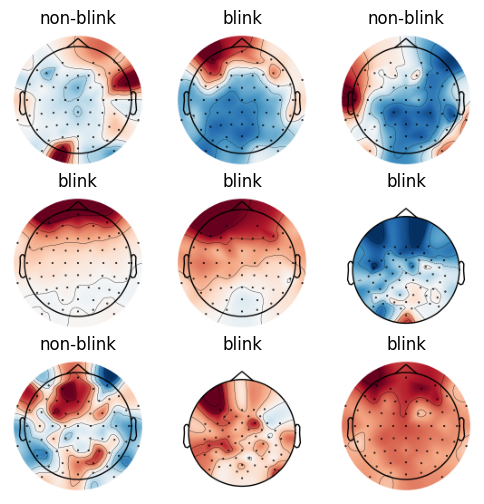

In [52]:
dls.show_batch(max_n=9, figsize=(6,6))

In [54]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.542390,0.418537,0.824013,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.450114,0.364642,0.826754,00:41
1,0.369958,0.333208,0.841009,00:38
2,0.312101,0.303914,0.855811,00:40
3,0.230591,0.319896,0.864583,00:41


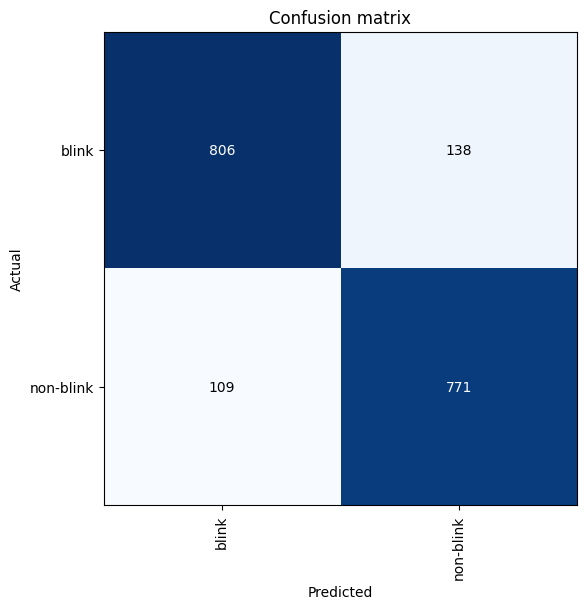

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))

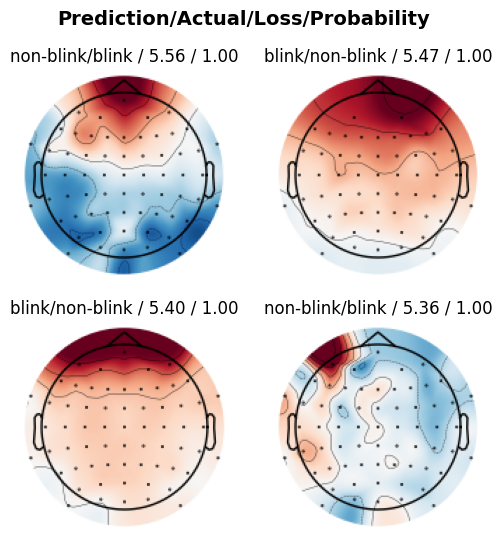

In [62]:
interp.plot_top_losses(k=4, figsize=(6, 6))

In [65]:
interp.print_classification_report()

              precision    recall  f1-score   support

       blink       0.80      0.88      0.84       944
   non-blink       0.85      0.77      0.81       880

    accuracy                           0.83      1824
   macro avg       0.83      0.82      0.83      1824
weighted avg       0.83      0.83      0.83      1824



# Iteration One

The first iteration of our model has an accuracy of 86% on the validation data. Validation loss is 0.3, which suggests the model is not entirely confident in it's predictions, even when it is correct.

Furthermore, 88% of blinks were correctly identified, whereas 77% of non-blinks were correctly identified. This makes sense, as half the training data are blinks, and the blinks are largely homogenous, with heavy frontal activity. Therefore, blinks are unlikely to be incorrectly classified. However, some saccades may look similar to blinks, and because of the strong representation the model holds for blinks this similarity may cause it to predict 'blink' for 'non-blink' saccades more often than the reverse.